In [1]:
import cv2
import numpy as np

def compute_optical_flow(img1, img2):
    # converte para float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Optical flow usando Farneback (rápido e bom para deep learning)
    flow = cv2.calcOpticalFlowFarneback(
        img1, img2,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )

    # flow tem shape (H, W, 2): componente horizontal e vertical
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    # magnitude e direção
    # magnitude = np.sqrt(u**2 + v**2)
    # direction = np.arctan2(v, u)

    # return magnitude, direction
    return u, v


In [2]:
import os
import h5py
import time
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from tensorflow import keras

In [3]:
# seed = 1747265027
seed = int(time.time()) % (2**32 - 1)  # ou: random.randint(0, 999999)
print(f"Usando seed: {seed}")

os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

Usando seed: 1770205806


In [4]:
train_path, valid_path, test_path = 'train.h5', 'valid.h5', 'test.h5'
ds = [f'../data/{i}' for i in ['TCIR-ATLN_EPAC_WPAC.h5', 'TCIR-CPAC_IO_SH.h5']]
channels = [0, 3]
generated_channels = [0]
img_w = 64
load_batch = 4096
epochs = 500
batch = 8

In [5]:
# with h5py.File("../data/TCIR-ATLN_EPAC_WPAC.h5") as file:
#     img = file['matrix'][0, :, :, 0]
#     img2 = file['matrix'][1, :, :, 0]
#     mag, direction, u, v = compute_optical_flow(img, img2)
#     # print(res.shape)
#     plt.imshow(v)
pass

In [6]:
def get_images_slice(images_shape, width):
    start = images_shape[1] // 2 - width // 2
    end = images_shape[1] // 2 + width // 2
    return slice(start, end)

In [7]:
def cut_images(images, width):
    slc = get_images_slice(images.shape, width)
    return images[:, slc, slc, :]

In [8]:
def clean_images(images):
    images = np.nan_to_num(images, copy=False)
    images[images > 1000] = 0
    return images

In [9]:
def split_data(images, info):
    years = [datetime.datetime.strptime(i, "%Y%m%d%H").year for i in list(info['time'])]
    years = np.array(years)
    train_values = (years >= 2003) & (years <= 2014)
    valid_values = (years >= 2015) & (years <= 2016)
    print(f"Train: {train_values}, Valid: {valid_values}")
    train_idx = np.where(train_values)[0]
    valid_idx = np.where(valid_values)[0]
    info = info['Vmax'].to_numpy()
    train_img, train_info = images[train_idx], info[train_idx]
    valid_img, valid_info = images[valid_idx], info[valid_idx]
    return (train_img, train_info), (valid_img, valid_info)

In [10]:
def get_mean(files, batch=1024, width=64):
    accumulators = np.zeros(len(channels))
    files_data_len = 0.0
    for fi, file in enumerate(files):
        with h5py.File(file, mode='r') as src:
            images = src['matrix']
            info = pd.read_hdf(file, key='info', mode='r')
            slc = get_images_slice(images.shape, width)
            file_len = images.shape[0]
            for i in range(0, file_len, batch):
                image_chunck = images[i: i + batch if i + batch < file_len else file_len, slc, slc, channels]
                info_chunck = info[i: i + batch if i + batch < file_len else file_len]
                image_chunck = clean_images(image_chunck)
                (train_image, _), _ = split_data(image_chunck, info_chunck)
                files_data_len += train_image.shape[0]
                for j in range(accumulators.shape[0]):
                    accumulators[j] += np.sum(train_image[:, :, :, j])
    means = accumulators / (files_data_len * width * width)
    return means

mean = get_mean(ds, batch=load_batch, width=img_w)
print(mean)

Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ... False False False], Valid: [False False False ...  True  True  True]
Train: [False False False ...  True  True  True], Valid: [ True  True  True ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ... False False False], Valid: [False False False ...  True  True  True]
Train: [False False False ...  True  True  True], Valid: [ True  True  True ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ T

In [11]:
def get_std(files, mean, batch=1024, width=64):
    accumulators = np.zeros(len(channels))
    files_data_len = 0.0
    for fi, file in enumerate(files):
        with h5py.File(file, mode='r') as src:
            images = src['matrix']
            info = pd.read_hdf(file, key='info', mode='r')
            slc = get_images_slice(images.shape, width)
            file_len = images.shape[0]
            for i in range(0, file_len, batch):
                image_chunck = images[i: i + batch if i + batch < file_len else file_len, slc, slc, channels]
                info_chunck = info[i: i + batch if i + batch < file_len else file_len]
                image_chunck = clean_images(image_chunck)
                (train_image, _), _ = split_data(image_chunck, info_chunck)
                files_data_len += train_image.shape[0]
                for j in range(accumulators.shape[0]):
                    accumulators[j] += np.sum((train_image[:, :, :, j] - mean[j]) ** 2)
    stds = accumulators / (files_data_len * width * width)
    stds = np.sqrt(stds)
    return stds

std = get_std(ds, mean, batch=load_batch, width=img_w)
print(std)

Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ... False False False], Valid: [False False False ...  True  True  True]
Train: [False False False ...  True  True  True], Valid: [ True  True  True ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ... False False False], Valid: [False False False ...  True  True  True]
Train: [False False False ...  True  True  True], Valid: [ True  True  True ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ True  True  True ...  True  True  True], Valid: [False False False ... False False False]
Train: [ T

In [12]:
ids = []
indexes = []
for i, d in enumerate(ds):
    info = pd.read_hdf(d, key='info', mode='r')[['ID', 'Vmax', 'time']]
    ids.append(list(info['ID'].unique()))
    print(ids[i])
    # indexes.append([info.index[info['ID'] == ide].sort(key=lambda val: datetime.datetime.strptime(val, "%Y%m%d%H")) for ide in ids[i]])
    sorted_indexes = []
    for ide in ids[i]:
        # Filtra o DataFrame para o ID atual
        sub_info = info[info['ID'] == ide]
        
        # Converte a coluna 'time' para datetime
        sub_info = sub_info.copy()
        sub_info['time_dt'] = sub_info['time'].apply(lambda t: datetime.datetime.strptime(str(t), "%Y%m%d%H"))
        
        # Ordena pelo datetime e pega os índices ordenados
        sorted_idx = sub_info.sort_values('time_dt').index.tolist()
        sorted_indexes.append(sorted_idx)
    
    indexes.append(sorted_indexes)

['200301L', '200302L', '200303L', '200304L', '200305L', '200306L', '200307L', '200308L', '200309L', '200310L', '200311L', '200312L', '200313L', '200314L', '200315L', '200316L', '200317L', '200318L', '200319L', '200320L', '200321L', '200401L', '200402L', '200403L', '200404L', '200405L', '200406L', '200407L', '200408L', '200409L', '200410L', '200411L', '200412L', '200413L', '200414L', '200415L', '200416L', '200501L', '200502L', '200503L', '200504L', '200505L', '200506L', '200507L', '200508L', '200509L', '200510L', '200511L', '200512L', '200513L', '200514L', '200515L', '200516L', '200517L', '200518L', '200519L', '200520L', '200521L', '200522L', '200523L', '200524L', '200525L', '200526L', '200527L', '200528L', '200529L', '200530L', '200531L', '200601L', '200602L', '200603L', '200604L', '200605L', '200606L', '200607L', '200608L', '200609L', '200610L', '200701L', '200702L', '200703L', '200704L', '200705L', '200706L', '200707L', '200708L', '200709L', '200710L', '200711L', '200712L', '200713L'

In [13]:

def pre_process(files, width, means, stds, batch=1024):
    # corta imagem grande o suficiente para poder rotacionar
    rotation_width = int(np.ceil(np.sqrt((width ** 2) * 2)))
    if rotation_width % 2 != 0:
        rotation_width += 1

    files_data_len = np.zeros(len(files))
    with h5py.File(train_path, 'w') as train, h5py.File(valid_path, 'w') as valid:
        for fi, file in enumerate(files): # itera sobre os arquivos
            file_cyclone_ids = ids[fi] #ids dos ciclones no arquivo
            file_cyclone_indexes = indexes[fi] # índices dos ciclones no arquivo
            with h5py.File(file, mode='r') as src:
                images = src['matrix']
                info = pd.read_hdf(file, key='info', mode='r')[['ID', 'Vmax', 'time']]
                slc = get_images_slice(images.shape, rotation_width)
                file_len = images.shape[0]
                for id_idx, cyclone_id in enumerate(file_cyclone_ids): # itera os ciclones (índice e ID)
                    cy_idxs = list(file_cyclone_indexes[id_idx]) # lista de índices das imagens de um ciclone
                    cyclone_images = images[cy_idxs, slc, slc]
                    cyclone_images = cyclone_images[:, :, :, channels]
                    cyclone_info = info.iloc[cy_idxs]
                    
                    cyclone_images = clean_images(cyclone_images)
                    for j, (m, s) in enumerate(zip(means, stds)):
                        cyclone_images[:, :, :, j] -= m
                        cyclone_images[:, :, :, j] /= s

                    generated_channels_idx = [channels.index(ch) for ch in generated_channels]

                    new_channels = []
                    for j in range(1, cyclone_images.shape[0]):
                        current_img = np.expand_dims(cyclone_images[j, :, :, generated_channels_idx][0], axis=-1)
                        previous_img = np.expand_dims(cyclone_images[j - 1, :, :, generated_channels_idx][0], axis=-1)
                        magnitude, direction = compute_optical_flow(current_img, previous_img)
                        magnitude = np.expand_dims(magnitude, axis=-1)
                        direction = np.expand_dims(direction, axis=-1)
                        conc = np.concatenate((magnitude, direction), axis=-1)
                        new_channels.append(conc)
                    new_channels = np.array(new_channels)

                    cyclone_images = cyclone_images[:-1]
                    cyclone_info = cyclone_info[:-1]
                    cyclone_images = np.concatenate((cyclone_images, new_channels), axis=-1)
                    img_new_shape = cyclone_images.shape[1:]

                    (train_img, train_info), (valid_img, valid_info) = split_data(cyclone_images, cyclone_info)

                    if train_img.shape[0] > 0:
                        if 'matrix' not in train:
                            train.create_dataset('matrix', shape=(0,) + img_new_shape, maxshape=(None,) + img_new_shape)
                        train['matrix'].resize(train['matrix'].shape[0] + train_img.shape[0], axis=0)
                        train['matrix'][-train_img.shape[0]:] = train_img
                        if 'info' not in train:
                            train.create_dataset('info', shape=(0,), maxshape=(None,))
                        train['info'].resize(train['info'].shape[0] + train_info.shape[0], axis=0)
                        train['info'][-train_info.shape[0]:] = train_info


                    if valid_img.shape[0] > 0:
                        if 'matrix' not in valid:
                            valid.create_dataset('matrix', shape=(0,) + img_new_shape, maxshape=(None,) + img_new_shape)
                        valid['matrix'].resize(valid['matrix'].shape[0] + valid_img.shape[0], axis=0)
                        valid['matrix'][-valid_img.shape[0]:] = valid_img
                        if 'info' not in valid:
                            valid.create_dataset('info', shape=(0,), maxshape=(None,))
                        valid['info'].resize(valid['info'].shape[0] + valid_info.shape[0], axis=0)
                        valid['info'][-valid_info.shape[0]:] = valid_info


pre_process(ds, img_w, mean, std, batch=load_batch)

Train: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True], Valid: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Train: [ True  True  True  True  True  True], Valid: [Fal

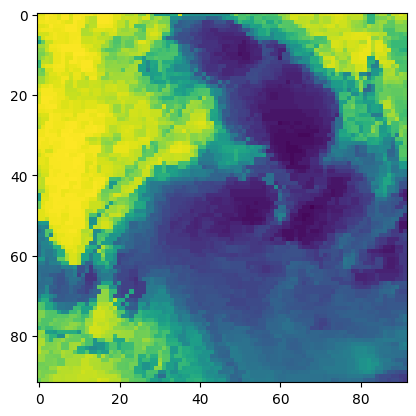

In [14]:
with h5py.File(train_path, mode='r') as f:
    img = f['matrix'][100, :, :, 0]
    plt.imshow(img)

In [15]:
with h5py.File(train_path, mode='r') as trainsrc, h5py.File(valid_path, mode='r') as validsrc:
    data_len = trainsrc['matrix'].shape[0]
    valid_data_len = validsrc['matrix'].shape[0]

    print('Dataset de treino: ', trainsrc['matrix'].shape)
    print('Dataset de validação: ', validsrc['matrix'].shape)

iter_train = data_len // batch
iter_valid = valid_data_len // batch

Dataset de treino:  (58940, 92, 92, 4)
Dataset de validação:  (10274, 92, 92, 4)


In [ ]:
def parse_example(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_image_tf(image)
    return image, label

def preprocess_image_tf(image):
    angle_rad = tf.random.uniform([], 0, 2 * np.pi)
    image_shape = tf.shape(image)[0:2]
    cx = tf.cast(image_shape[1] / 2, tf.float32)
    cy = tf.cast(image_shape[0] / 2, tf.float32)
    cos_a = tf.math.cos(angle_rad)
    sin_a = tf.math.sin(angle_rad)
    transform = tf.stack([
        cos_a, -sin_a, (1 - cos_a) * cx + sin_a * cy,
        sin_a,  cos_a, (1 - cos_a) * cy - sin_a * cx,
        0.0,    0.0
    ])
    transform = tf.reshape(transform, [8])
    transform = tf.expand_dims(transform, 0)
    image = tf.expand_dims(image, 0)
    rotated = tf.raw_ops.ImageProjectiveTransformV3(
        images=image,
        transforms=transform,
        output_shape=image_shape,
        interpolation="BILINEAR",
        fill_mode="REFLECT",
        fill_value=0.0
    )
    rotated = tf.squeeze(rotated, 0)
    return tf.image.resize_with_crop_or_pad(rotated, img_w, img_w)

def load_dataset(file, batch_size):
    with h5py.File(file, 'r') as f:
        images = tf.constant(f['matrix'][:])
        labels = tf.constant(f['info'][:])

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [17]:
def get_data(file):
    with h5py.File(file, mode='r') as src:
        images = src['matrix'][:]
        info = src['info'][:]
        images = cut_images(images, img_w)
        return tf.constant(images), tf.constant(info)

In [19]:
train_ds = load_dataset(train_path, batch)
valid_ds = get_data(valid_path)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:

def build_model(input_shape, strides=(2, 2)):
    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
    reg = keras.regularizers.L2(1e-5)
    model = keras.models.Sequential()
    model.add(keras.layers.Input(input_shape))
    model.add(keras.layers.Conv2D(16, (4, 4), strides=strides, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))
    model.add(keras.layers.Conv2D(32, (3, 3), strides=strides, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))
    model.add(keras.layers.Conv2D(64, (3, 3), strides=strides, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))
    model.add(keras.layers.Conv2D(128, (3, 3), strides=strides, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))
    model.add(keras.layers.Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))
    model.add(keras.layers.Dense(1, activation='linear', kernel_initializer=initializer, kernel_regularizer=reg, bias_initializer=initializer, bias_regularizer=reg))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=.1e-4), loss='mse', metrics=['mse'])
    return model

In [ ]:
def training_number():
    counter = 0
    while True:
        yield counter
        counter += 1

training_n_gen = training_number()

In [ ]:
training_n = next(training_n_gen)

model = build_model((img_w, img_w, len(channels)),)
model.summary()

best_model_path = '{epoch:03d}-{val_loss:.2f}.keras'
callback = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path,
                           monitor='val_loss',
                           verbose=0,
                           save_best_only=True,
                           mode='min')

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=epochs,
        steps_per_epoch=iter_train,
        validation_steps=iter_valid,
        callbacks=[callback],
    )

model_info_dict = {
    "seed": seed,
    "shape": [
        img_w,
        img_w,
        len(channels)
    ],
    "channels": channels,
    "dataset": ds,
    "batch": batch,
    "normparams": [{"mean": mean[i], "std": std[i]} for i in range(len(channels))],
    "validmse": list(history.history['val_loss']),
    "trainingmse": list(history.history['loss'])
}

json_info = json.dumps(model_info_dict, indent=4)
with open(f'n{training_n}-model_info.json', 'w') as outfile:
    outfile.write(json_info)